<a href="https://colab.research.google.com/github/donutellah/philippine-stocks-network/blob/main/philippine_stocks_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install beautifulsoup4 requests pandas numpy matplotlib seaborn networkx scipy

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import time
import json
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")

All libraries imported successfully


In [ ]:
def search_pse_company_id(stock_symbol):
    """Search PSE Edge and extract company IDs"""
    url = "https://edge.pse.com.ph/companyDirectory/search.ax"
    params = {'keyword': stock_symbol}
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
        'Referer': 'https://edge.pse.com.ph/'
    }

    try:
        response = requests.post(url, headers=headers, data=params, timeout=15)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            table = soup.find('table', class_='list')
            if table:
                rows = table.find_all('tr')
                for row in rows:
                    cells = row.find_all('td')
                    if len(cells) >= 2:
                        symbol_cell = cells[1]
                        symbol_link = symbol_cell.find('a')
                        if symbol_link:
                            symbol_text = symbol_link.get_text(strip=True)
                            if symbol_text == stock_symbol:
                                onclick = symbol_link.get('onclick', '')
                                match = re.search(r"cmDetail\('(\d+)','(\d+)'\)", onclick)
                                if match:
                                    return {
                                        'symbol': stock_symbol,
                                        'company_name': cells[0].get_text(strip=True),
                                        'company_id': match.group(1),
                                        'security_id': match.group(2)
                                    }
    except Exception as e:
        print(f"Error: {e}")
    return None

def get_pse_historical_data(company_id, security_id, start_date='01-01-2023', end_date='12-31-2025'):
    """Download historical stock data from PSE Edge"""
    url = 'https://edge.pse.com.ph/common/DisclosureCht.ax'
    payload = {
        'cmpy_id': company_id,
        'security_id': security_id,
        'startDate': start_date,
        'endDate': end_date
    }
    headers = {
        'Content-Type': 'application/json',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
        'Referer': 'https://edge.pse.com.ph/',
        'X-Requested-With': 'XMLHttpRequest'
    }

    try:
        response = requests.post(url, json=payload, headers=headers, timeout=15)
        if response.status_code == 200:
            data = response.json()
            return data.get('chartData', [])
    except Exception as e:
        print(f"Error: {e}")
    return None

def convert_to_dataframe(chart_data):
    """Convert PSE data to pandas DataFrame"""
    if not chart_data:
        return None
    df = pd.DataFrame(chart_data)
    df['Date'] = pd.to_datetime(df['CHART_DATE'])
    df = df.rename(columns={'CLOSE': 'Close'})
    df = df[['Date', 'Close']]
    df = df.set_index('Date')
    df = df.sort_index()
    df = df[~df.index.duplicated(keep='first')]
    return df

print("Functions defined successfully")

Functions defined successfully


In [ ]:
print("="*70)
print("DOWNLOADING PSEi 30 STOCKS - COMPLETE DATASET")
print("="*70)
print()

# Complete list of 30 PSEi stocks tickers
psei_30_stocks = [
    'AC', 'AEV', 'AGI', 'ALI', 'BDO', 'BPI', 'CBC', 'DMC', 'GLO', 'ICT',
    'JFC', 'JGS', 'LOTO', 'MBT', 'MER', 'SCC', 'SMC', 'SM', 'SMPH', 'ACEN',
    'LTG', 'TEL', 'URC', 'PGOLD', 'EMI', 'GTCAP', 'CNPF', 'AREIT', 'CNVRG', 'MONDE'
]

print(f"Downloading {len(psei_30_stocks)} stocks...")
print(f"Date range: January 1, 2023 - December 31, 2025")
print()

all_data = {}
company_info = {}

for stock in psei_30_stocks:
    print(f"Processing {stock}...", end=' ')

    # Search for company
    info = search_pse_company_id(stock)

    if info:
        company_info[stock] = info

        # Download historical data
        chart_data = get_pse_historical_data(info['company_id'], info['security_id'])

        if chart_data:
            df = convert_to_dataframe(chart_data)
            if df is not None and len(df) > 0:
                all_data[stock] = df
                print(f"✓ {len(df)} days")
            else:
                print(f"✗ No data")
        else:
            print(f"✗ Download failed")
    else:
        print(f"✗ Not found")

    time.sleep(0.5)  # Be polite to server

print()
print("="*70)
print(f"DOWNLOAD COMPLETE: {len(all_data)}/{len(psei_30_stocks)} stocks")
print("="*70)

DOWNLOADING PSEi 30 STOCKS - COMPLETE DATASET

Date range: January 1, 2023 - December 31, 2025

Processing AC... ✓ 730 days
Processing AEV... ✓ 730 days
Processing AGI... ✓ 730 days
Processing ALI... ✓ 730 days
Processing BDO... ✓ 730 days
Processing BPI... ✓ 730 days
Processing CBC... ✓ 687 days
Processing DMC... ✓ 730 days
Processing GLO... ✓ 730 days
Processing ICT... ✓ 730 days
Processing JFC... ✓ 730 days
Processing JGS... ✓ 730 days
Processing LOTO... ✓ 652 days
Processing MBT... ✓ 730 days
Processing MER... ✓ 730 days
Processing SCC... ✓ 730 days
Processing SMC... ✓ 730 days
Processing SM... ✓ 730 days
Processing SMPH... ✓ 730 days
Processing ACEN... ✓ 730 days
Processing LTG... ✓ 730 days
Processing TEL... ✓ 730 days
Processing URC... ✓ 730 days
Processing PGOLD... ✓ 730 days
Processing EMI... ✓ 730 days
Processing GTCAP... ✓ 730 days
Processing CNPF... ✓ 730 days
Processing AREIT... ✓ 730 days
Processing CNVRG... ✓ 730 days
Processing MONDE... ✓ 730 days

DOWNLOAD COMPLETE: 30

In [ ]:
# Combine all stocks into one DataFrame
closing_prices = pd.DataFrame()

for stock, df in all_data.items():
    closing_prices[stock] = df['Close']

# Save to CSV
closing_prices.to_csv('psei_30_stocks_complete_2023_2025.csv')

print("✓ Dataset saved: psei_30_stocks_complete_2023_2025.csv")
print()
print("Dataset Summary:")
print(f"  Stocks: {len(closing_prices.columns)}")
print(f"  Trading days: {len(closing_prices)}")
print(f"  Date range: {closing_prices.index.min().date()} to {closing_prices.index.max().date()}")
print()
print("Stock tickers:")
print(sorted(closing_prices.columns.tolist()))

✓ Dataset saved: psei_30_stocks_complete_2023_2025.csv

Dataset Summary:
  Stocks: 30
  Trading days: 730
  Date range: 2023-01-03 to 2025-12-29

Stock tickers:
['AC', 'ACEN', 'AEV', 'AGI', 'ALI', 'AREIT', 'BDO', 'BPI', 'CBC', 'CNPF', 'CNVRG', 'DMC', 'EMI', 'GLO', 'GTCAP', 'ICT', 'JFC', 'JGS', 'LOTO', 'LTG', 'MBT', 'MER', 'MONDE', 'PGOLD', 'SCC', 'SM', 'SMC', 'SMPH', 'TEL', 'URC']


In [ ]:
# Display data preview
print("Data Preview:")
print(closing_prices.head(10))
print()
print("Data Info:")
print(f"  Shape: {closing_prices.shape}")
print(f"  Missing values: {closing_prices.isnull().sum().sum()}")
print(f"  Memory usage: {closing_prices.memory_usage(deep=True).sum() / 1024:.2f} KB")

Data Preview:
               AC    AEV    AGI    ALI    BDO    BPI    CBC    DMC     GLO  \
Date                                                                         
2023-01-03  687.5  57.70  11.96  30.40  107.9   98.0  27.50  11.64  2220.0   
2023-01-04  687.0  58.90  11.96  31.25  111.5   98.3  27.45  11.80  2218.0   
2023-01-05  690.5  59.95  11.52  31.25  114.0   99.8  27.45  11.80  2164.0   
2023-01-06  684.0  58.70  11.40  30.25  111.0  100.6  27.45  11.72  2126.0   
2023-01-09  712.0  60.00  11.80  30.70  112.4  106.0  27.50  11.80  2132.0   
2023-01-10  703.0  59.00  11.80  30.00  110.9  104.5  27.30  11.70  2114.0   
2023-01-11  707.5  58.70  11.92  30.00  109.9  101.3  27.20  11.80  2060.0   
2023-01-12  732.0  59.50  11.96  31.00  114.0  103.1  27.45  12.18  2060.0   
2023-01-13  739.0  59.70  12.10  31.00  119.0  110.0  27.60  12.22  2098.0   
2023-01-16  768.0  59.05  12.52  31.60  125.5  112.4  27.70  12.60  2102.0   

              ICT  ...   LTG     TEL    URC  PGOL

In [ ]:
print("="*70)
print("HANDLING MISSING DATA")
print("="*70)
print()

# Check which stocks have missing data
print("Missing values per stock:")
missing_by_stock = closing_prices.isnull().sum()
missing_by_stock = missing_by_stock[missing_by_stock > 0].sort_values(ascending=False)

for stock, count in missing_by_stock.items():
    percentage = (count / len(closing_prices)) * 100
    print(f"  {stock:8s}: {count:3d} missing ({percentage:5.2f}%)")

print()

# Forward fill missing values (use last known price)
# This is standard practice for stock market data
closing_prices_filled = closing_prices.fillna(method='ffill')

# If there are any remaining NaN at the beginning, backfill
closing_prices_filled = closing_prices_filled.fillna(method='bfill')

# Verify no more missing values
remaining_missing = closing_prices_filled.isnull().sum().sum()

print(f"After filling:")
print(f"  Missing values: {remaining_missing}")
print()

if remaining_missing == 0:
    print("✓ All missing values handled successfully")

    # Save cleaned dataset
    closing_prices_filled.to_csv('psei_30_stocks_complete_cleaned.csv')
    print("✓ Saved cleaned dataset: psei_30_stocks_complete_cleaned.csv")
else:
    print("⚠ Warning: Some missing values remain")

# Use the filled dataset going forward
data = closing_prices_filled
print()
print(f"Final dataset: {data.shape[0]} days × {data.shape[1]} stocks")

HANDLING MISSING DATA

Missing values per stock:
  LOTO    :  78 missing (10.68%)
  CBC     :  43 missing ( 5.89%)

After filling:
  Missing values: 0

✓ All missing values handled successfully
✓ Saved cleaned dataset: psei_30_stocks_complete_cleaned.csv

Final dataset: 730 days × 30 stocks


In [ ]:
# Sector classification for all 30 stocks
sector_map = {
    'AC': 'Holding Firms',
    'AEV': 'Holding Firms',
    'AGI': 'Holding Firms',
    'ALI': 'Property',
    'BDO': 'Financials',
    'BPI': 'Financials',
    'CBC': 'Financials',
    'DMC': 'Holding Firms',
    'GLO': 'Services',
    'ICT': 'Services',
    'JFC': 'Industrials',
    'JGS': 'Holding Firms',
    'LOTO': 'Services',
    'MBT': 'Financials',
    'MER': 'Services',
    'SCC': 'Mining & Oil',
    'SMC': 'Industrials',
    'SM': 'Holding Firms',
    'SMPH': 'Property',
    'ACEN': 'Services',
    'LTG': 'Holding Firms',
    'TEL': 'Services',
    'URC': 'Industrials',
    'PGOLD': 'Services',
    'EMI': 'Industrials',
    'GTCAP': 'Holding Firms',
    'CNPF': 'Industrials',
    'AREIT': 'Property',
    'CNVRG': 'Services',
    'MONDE': 'Industrials'
}

# Count stocks per sector
from collections import Counter
sector_counts = Counter(sector_map.values())

print("Sector Distribution:")
for sector, count in sorted(sector_counts.items()):
    print(f"  {sector:15s}: {count} stocks")

print()
print("✓ Sector mapping defined")

Sector Distribution:
  Financials     : 4 stocks
  Holding Firms  : 8 stocks
  Industrials    : 6 stocks
  Mining & Oil   : 1 stocks
  Property       : 3 stocks
  Services       : 8 stocks

✓ Sector mapping defined


In [ ]:
print("="*70)
print("STEP 1: CALCULATING LOGARITHMIC RETURNS")
print("="*70)
print()

# Calculate log returns: R_i,t = ln(P_i(t)) - ln(P_i(t-1))
returns = np.log(data / data.shift(1))
returns = returns.dropna()

print(f"✓ Calculated logarithmic returns")
print(f"  Returns shape: {returns.shape}")
print(f"  Date range: {returns.index.min().date()} to {returns.index.max().date()}")
print()

# Statistics
print("Return Statistics (annualized):")
mean_returns = returns.mean() * 252  # Annualize (252 trading days)
std_returns = returns.std() * np.sqrt(252)

print(f"  Mean return range: [{mean_returns.min():.2%}, {mean_returns.max():.2%}]")
print(f"  Volatility range: [{std_returns.min():.2%}, {std_returns.max():.2%}]")
print()

# Top 5 highest/lowest average returns
print("Top 5 Performing Stocks (Annualized Return):")
for i, (stock, ret) in enumerate(mean_returns.nlargest(5).items(), 1):
    print(f"  {i}. {stock:8s}: {ret:+7.2%}")

print()
print("Bottom 5 Performing Stocks (Annualized Return):")
for i, (stock, ret) in enumerate(mean_returns.nsmallest(5).items(), 1):
    print(f"  {i}. {stock:8s}: {ret:+7.2%}")

print()

# Save returns
returns.to_csv('stock_log_returns.csv')
print("✓ Saved: stock_log_returns.csv")

STEP 1: CALCULATING LOGARITHMIC RETURNS

✓ Calculated logarithmic returns
  Returns shape: (729, 30)
  Date range: 2023-01-04 to 2025-12-29

Return Statistics (annualized):
  Mean return range: [-37.25%, 36.37%]
  Volatility range: [17.70%, 65.94%]

Top 5 Performing Stocks (Annualized Return):
  1. ICT     : +36.37%
  2. CBC     : +25.20%
  3. MER     : +22.22%
  4. LTG     : +16.05%
  5. CNPF    : +14.42%

Bottom 5 Performing Stocks (Annualized Return):
  1. ACEN    : -37.25%
  2. JGS     : -27.24%
  3. AEV     : -24.99%
  4. MONDE   : -24.90%
  5. URC     : -24.04%

✓ Saved: stock_log_returns.csv


In [ ]:
print("="*70)
print("STEP 2: COMPUTING CORRELATION MATRIX")
print("="*70)
print()

# Pearson correlation (full-sample)
correlation_matrix = returns.corr()

# Get upper triangle values (no diagonal)
corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]

print(f"✓ Computed {len(data.columns)}×{len(data.columns)} correlation matrix")
print()
print("Correlation Statistics:")
print(f"  Mean: {corr_values.mean():.4f}")
print(f"  Median: {np.median(corr_values):.4f}")
print(f"  Std Dev: {corr_values.std():.4f}")
print(f"  Min: {corr_values.min():.4f}")
print(f"  Max: {corr_values.max():.4f}")
print()

# Top 10 most correlated pairs
print("Top 10 Most Correlated Stock Pairs:")
pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        stock1 = correlation_matrix.columns[i]
        stock2 = correlation_matrix.columns[j]
        corr = correlation_matrix.iloc[i, j]
        pairs.append((stock1, stock2, corr))

pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for rank, (s1, s2, corr) in enumerate(pairs[:10], 1):
    sector1 = sector_map.get(s1, '?')
    sector2 = sector_map.get(s2, '?')
    print(f"  {rank:2d}. {s1:8s} ({sector1:15s}) - {s2:8s} ({sector2:15s}): {corr:7.4f}")

print()

# Save
correlation_matrix.to_csv('correlation_matrix.csv')
print("✓ Saved: correlation_matrix.csv")

STEP 2: COMPUTING CORRELATION MATRIX

✓ Computed 30×30 correlation matrix

Correlation Statistics:
  Mean: 0.1440
  Median: 0.1567
  Std Dev: 0.1024
  Min: -0.3029
  Max: 0.4781

Top 10 Most Correlated Stock Pairs:
   1. ALI      (Property       ) - SMPH     (Property       ):  0.4781
   2. AC       (Holding Firms  ) - SMPH     (Property       ):  0.4217
   3. AC       (Holding Firms  ) - SM       (Holding Firms  ):  0.3911
   4. JGS      (Holding Firms  ) - URC      (Industrials    ):  0.3769
   5. DMC      (Holding Firms  ) - SCC      (Mining & Oil   ):  0.3664
   6. ALI      (Property       ) - JGS      (Holding Firms  ):  0.3641
   7. AC       (Holding Firms  ) - ALI      (Property       ):  0.3634
   8. JGS      (Holding Firms  ) - SMPH     (Property       ):  0.3493
   9. GLO      (Services       ) - TEL      (Services       ):  0.3380
  10. AC       (Holding Firms  ) - JGS      (Holding Firms  ):  0.3365

✓ Saved: correlation_matrix.csv


In [ ]:
print("="*70)
print("STEP 3: TRANSFORMING TO DISTANCE MATRIX")
print("="*70)
print()

# Distance transformation: d_ij = sqrt(2(1 - ρ_ij))
distance_matrix = np.sqrt(2 * (1 - correlation_matrix))

dist_values = distance_matrix.values[np.triu_indices_from(distance_matrix.values, k=1)]

print(f"✓ Computed distance matrix")
print()
print("Distance Statistics:")
print(f"  Mean: {dist_values.mean():.4f}")
print(f"  Median: {np.median(dist_values):.4f}")
print(f"  Min: {dist_values.min():.4f}")
print(f"  Max: {dist_values.max():.4f}")
print()

# Verify Euclidean properties
print("Distance Matrix Properties:")
print(f"  ✓ Non-negative: {(distance_matrix.values >= 0).all()}")
print(f"  ✓ Symmetric: {np.allclose(distance_matrix, distance_matrix.T)}")
print(f"  ✓ Zero diagonal: {np.allclose(np.diag(distance_matrix), 0)}")
print()

# Save
distance_matrix.to_csv('distance_matrix.csv')
print("✓ Saved: distance_matrix.csv")

STEP 3: TRANSFORMING TO DISTANCE MATRIX

✓ Computed distance matrix

Distance Statistics:
  Mean: 1.3061
  Median: 1.2987
  Min: 1.0216
  Max: 1.6142

Distance Matrix Properties:
  ✓ Non-negative: True
  ✓ Symmetric: True
  ✓ Zero diagonal: True

✓ Saved: distance_matrix.csv


In [ ]:
print("="*70)
print("STEP 4: CONSTRUCTING MINIMUM SPANNING TREE")
print("="*70)
print()

# Create complete graph
G_full = nx.Graph()
stocks = list(correlation_matrix.columns)

# Add nodes with sector attribute
for stock in stocks:
    G_full.add_node(stock, sector=sector_map.get(stock, 'Unknown'))

# Add edges with distance weights
for i in range(len(stocks)):
    for j in range(i+1, len(stocks)):
        G_full.add_edge(
            stocks[i],
            stocks[j],
            weight=distance_matrix.iloc[i, j],
            correlation=correlation_matrix.iloc[i, j]
        )

# Construct MST using Kruskal's algorithm
MST = nx.minimum_spanning_tree(G_full, weight='weight')

print(f"✓ Minimum Spanning Tree constructed")
print()
print("MST Properties:")
print(f"  Nodes: {MST.number_of_nodes()}")
print(f"  Edges: {MST.number_of_edges()} (expected: {len(stocks)-1})")
print(f"  Total weight: {sum(data['weight'] for _, _, data in MST.edges(data=True)):.4f}")
print()

# MST edge list
print("Sample MST Edges (showing first 10):")
mst_edges = [(u, v, data['correlation']) for u, v, data in MST.edges(data=True)]
mst_edges_sorted = sorted(mst_edges, key=lambda x: abs(x[2]), reverse=True)

for i, (u, v, corr) in enumerate(mst_edges_sorted[:10], 1):
    print(f"  {i:2d}. {u:8s} - {v:8s}: ρ = {corr:7.4f}")

print()
print("✓ MST complete")

STEP 4: CONSTRUCTING MINIMUM SPANNING TREE

✓ Minimum Spanning Tree constructed

MST Properties:
  Nodes: 30
  Edges: 29 (expected: 29)
  Total weight: 34.5429

Sample MST Edges (showing first 10):
   1. ALI      - SMPH    : ρ =  0.4781
   2. AC       - SMPH    : ρ =  0.4217
   3. AC       - SM      : ρ =  0.3911
   4. JGS      - URC     : ρ =  0.3769
   5. DMC      - SCC     : ρ =  0.3664
   6. ALI      - JGS     : ρ =  0.3641
   7. GLO      - TEL     : ρ =  0.3380
   8. AEV      - JGS     : ρ =  0.3355
   9. SMPH     - GTCAP   : ρ =  0.3277
  10. BDO      - MBT     : ρ =  0.3268

✓ MST complete


In [ ]:
print("="*70)
print("STEP 5: CONSTRUCTING THRESHOLD NETWORKS")
print("="*70)
print()

thresholds = [0.3, 0.4, 0.5]
threshold_networks = {}

for tau in thresholds:
    G_tau = nx.Graph()

    # Add nodes
    for stock in stocks:
        G_tau.add_node(stock, sector=sector_map.get(stock, 'Unknown'))

    # Add edges where |correlation| >= tau
    for i in range(len(stocks)):
        for j in range(i+1, len(stocks)):
            corr = correlation_matrix.iloc[i, j]
            if abs(corr) >= tau:
                G_tau.add_edge(
                    stocks[i],
                    stocks[j],
                    weight=abs(corr),
                    correlation=corr
                )

    threshold_networks[tau] = G_tau

    print(f"  τ = {tau}: {G_tau.number_of_edges():3d} edges, density = {nx.density(G_tau):.4f}")

print()
print("✓ Threshold networks constructed")

STEP 5: CONSTRUCTING THRESHOLD NETWORKS

  τ = 0.3:  26 edges, density = 0.0598
  τ = 0.4:   2 edges, density = 0.0046
  τ = 0.5:   0 edges, density = 0.0000

✓ Threshold networks constructed


In [ ]:
print("="*70)
print("STEP 6: CENTRALITY ANALYSIS")
print("="*70)
print()

# --- MST CENTRALITY ---
print("A. MST CENTRALITY MEASURES")
print("-" * 70)

# Degree centrality
degree_centrality_mst = nx.degree_centrality(MST)
degree_dict_mst = dict(MST.degree())

print("\nTop 5 by Degree Centrality (MST):")
sorted_degree = sorted(degree_centrality_mst.items(), key=lambda x: x[1], reverse=True)
for rank, (stock, cent) in enumerate(sorted_degree[:5], 1):
    connections = degree_dict_mst[stock]
    sector = sector_map.get(stock, '?')
    print(f"  {rank}. {stock:8s} ({sector:15s}): {cent:.4f} ({connections} connections)")

# Betweenness centrality
betweenness_mst = nx.betweenness_centrality(MST, weight='weight')
print("\nTop 5 by Betweenness Centrality (MST):")
sorted_between = sorted(betweenness_mst.items(), key=lambda x: x[1], reverse=True)
for rank, (stock, cent) in enumerate(sorted_between[:5], 1):
    sector = sector_map.get(stock, '?')
    print(f"  {rank}. {stock:8s} ({sector:15s}): {cent:.4f}")

# Closeness centrality
closeness_mst = nx.closeness_centrality(MST, distance='weight')
print("\nTop 5 by Closeness Centrality (MST):")
sorted_close = sorted(closeness_mst.items(), key=lambda x: x[1], reverse=True)
for rank, (stock, cent) in enumerate(sorted_close[:5], 1):
    sector = sector_map.get(stock, '?')
    print(f"  {rank}. {stock:8s} ({sector:15s}): {cent:.4f}")

# --- THRESHOLD NETWORK CENTRALITY (τ=0.3) ---
print("\n\nB. THRESHOLD NETWORK (τ=0.3) CENTRALITY")
print("-" * 70)

G_03 = threshold_networks[0.3]

# Weighted degree
weighted_degree = {}
for node in G_03.nodes():
    weighted_degree[node] = sum(G_03[node][neighbor]['weight']
                               for neighbor in G_03.neighbors(node))

print("\nTop 5 by Weighted Degree:")
sorted_wd = sorted(weighted_degree.items(), key=lambda x: x[1], reverse=True)
for rank, (stock, wd) in enumerate(sorted_wd[:5], 1):
    sector = sector_map.get(stock, '?')
    degree = G_03.degree(stock)
    print(f"  {rank}. {stock:8s} ({sector:15s}): {wd:.4f} ({degree} connections)")

# Clustering coefficient
clustering_03 = nx.clustering(G_03)
print("\nTop 5 by Clustering Coefficient:")
sorted_clust = sorted(clustering_03.items(), key=lambda x: x[1], reverse=True)
for rank, (stock, cc) in enumerate(sorted_clust[:5], 1):
    sector = sector_map.get(stock, '?')
    print(f"  {rank}. {stock:8s} ({sector:15s}): {cc:.4f}")

print()
print("✓ Centrality analysis complete")

STEP 6: CENTRALITY ANALYSIS

A. MST CENTRALITY MEASURES
----------------------------------------------------------------------

Top 5 by Degree Centrality (MST):
  1. ALI      (Property       ): 0.2069 (6 connections)
  2. AC       (Holding Firms  ): 0.1724 (5 connections)
  3. JGS      (Holding Firms  ): 0.1379 (4 connections)
  4. SMPH     (Property       ): 0.1379 (4 connections)
  5. MBT      (Financials     ): 0.1034 (3 connections)

Top 5 by Betweenness Centrality (MST):
  1. ALI      (Property       ): 0.6798
  2. SMPH     (Property       ): 0.6379
  3. AC       (Holding Firms  ): 0.4655
  4. JGS      (Holding Firms  ): 0.3153
  5. AGI      (Holding Firms  ): 0.2463

Top 5 by Closeness Centrality (MST):
  1. SMPH     (Property       ): 0.3284
  2. ALI      (Property       ): 0.3284
  3. AC       (Holding Firms  ): 0.2865
  4. JGS      (Holding Firms  ): 0.2670
  5. AGI      (Holding Firms  ): 0.2565


B. THRESHOLD NETWORK (τ=0.3) CENTRALITY
--------------------------------------

In [ ]:
print("="*70)
print("STEP 7: SECTORAL CLUSTERING ANALYSIS")
print("="*70)
print()

# Count within-sector vs between-sector edges (MST)
within_sector = 0
between_sector = 0

for u, v in MST.edges():
    if sector_map.get(u) == sector_map.get(v):
        within_sector += 1
    else:
        between_sector += 1

total_mst_edges = MST.number_of_edges()

print("MST Edge Distribution:")
print(f"  Within-sector edges: {within_sector} ({within_sector/total_mst_edges*100:.1f}%)")
print(f"  Between-sector edges: {between_sector} ({between_sector/total_mst_edges*100:.1f}%)")
print()

# Sector connectivity matrix
sectors = sorted(set(sector_map.values()))
sector_connectivity = pd.DataFrame(0, index=sectors, columns=sectors)

for u, v in MST.edges():
    sector_u = sector_map.get(u, 'Unknown')
    sector_v = sector_map.get(v, 'Unknown')
    sector_connectivity.loc[sector_u, sector_v] += 1
    sector_connectivity.loc[sector_v, sector_u] += 1

print("Sector Connectivity Matrix (MST):")
print(sector_connectivity)
print()

# Save
sector_connectivity.to_csv('sector_connectivity.csv')
print("✓ Saved: sector_connectivity.csv")

STEP 7: SECTORAL CLUSTERING ANALYSIS

MST Edge Distribution:
  Within-sector edges: 9 (31.0%)
  Between-sector edges: 20 (69.0%)

Sector Connectivity Matrix (MST):
               Financials  Holding Firms  Industrials  Mining & Oil  Property  \
Financials              4              1            0             0         1   
Holding Firms           1              4            2             1         5   
Industrials             0              2            6             0         1   
Mining & Oil            0              1            0             0         0   
Property                1              5            1             0         2   
Services                1              4            1             0         3   

               Services  
Financials            1  
Holding Firms         4  
Industrials           1  
Mining & Oil          0  
Property              3  
Services              2  

✓ Saved: sector_connectivity.csv


In [ ]:
print("="*70)
print("STEP 8: NETWORK STATISTICS SUMMARY")
print("="*70)
print()

print("MST STATISTICS:")
print(f"  Nodes: {MST.number_of_nodes()}")
print(f"  Edges: {MST.number_of_edges()}")
print(f"  Density: {nx.density(MST):.6f}")
print(f"  Avg Degree: {sum(dict(MST.degree()).values()) / MST.number_of_nodes():.4f}")
print(f"  Diameter: {nx.diameter(MST)}")
print(f"  Avg Path Length: {nx.average_shortest_path_length(MST):.4f}")
print()

print("THRESHOLD NETWORK (τ=0.3) STATISTICS:")
print(f"  Nodes: {G_03.number_of_nodes()}")
print(f"  Edges: {G_03.number_of_edges()}")
print(f"  Density: {nx.density(G_03):.4f}")
print(f"  Avg Degree: {sum(dict(G_03.degree()).values()) / G_03.number_of_nodes():.4f}")
print(f"  Avg Clustering: {nx.average_clustering(G_03):.4f}")
print()

# Save summary
network_stats = pd.DataFrame({
    'Metric': ['Nodes', 'Edges', 'Density', 'Avg Degree', 'Diameter', 'Avg Path Length', 'Avg Clustering'],
    'MST': [
        MST.number_of_nodes(),
        MST.number_of_edges(),
        f"{nx.density(MST):.6f}",
        f"{sum(dict(MST.degree()).values()) / MST.number_of_nodes():.4f}",
        nx.diameter(MST),
        f"{nx.average_shortest_path_length(MST):.4f}",
        'N/A'
    ],
    'Threshold_0.3': [
        G_03.number_of_nodes(),
        G_03.number_of_edges(),
        f"{nx.density(G_03):.4f}",
        f"{sum(dict(G_03.degree()).values()) / G_03.number_of_nodes():.4f}",
        'N/A',
        'N/A',
        f"{nx.average_clustering(G_03):.4f}"
    ]
})

network_stats.to_csv('network_statistics.csv', index=False)
print("✓ Saved: network_statistics.csv")

STEP 8: NETWORK STATISTICS SUMMARY

MST STATISTICS:
  Nodes: 30
  Edges: 29
  Density: 0.066667
  Avg Degree: 1.9333
  Diameter: 9
  Avg Path Length: 4.2460

THRESHOLD NETWORK (τ=0.3) STATISTICS:
  Nodes: 30
  Edges: 26
  Density: 0.0598
  Avg Degree: 1.7333
  Avg Clustering: 0.1340

✓ Saved: network_statistics.csv


In [ ]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Sector color scheme
sector_colors = {
    'Financials': '#FF6B6B',
    'Property': '#4ECDC4',
    'Holding Firms': '#45B7D1',
    'Industrials': '#FFA07A',
    'Services': '#98D8C8',
    'Mining & Oil': '#F7DC6F'
}

print("✓ Visualization settings configured")

✓ Visualization settings configured


Creating Visualization 1: Correlation Heatmap...


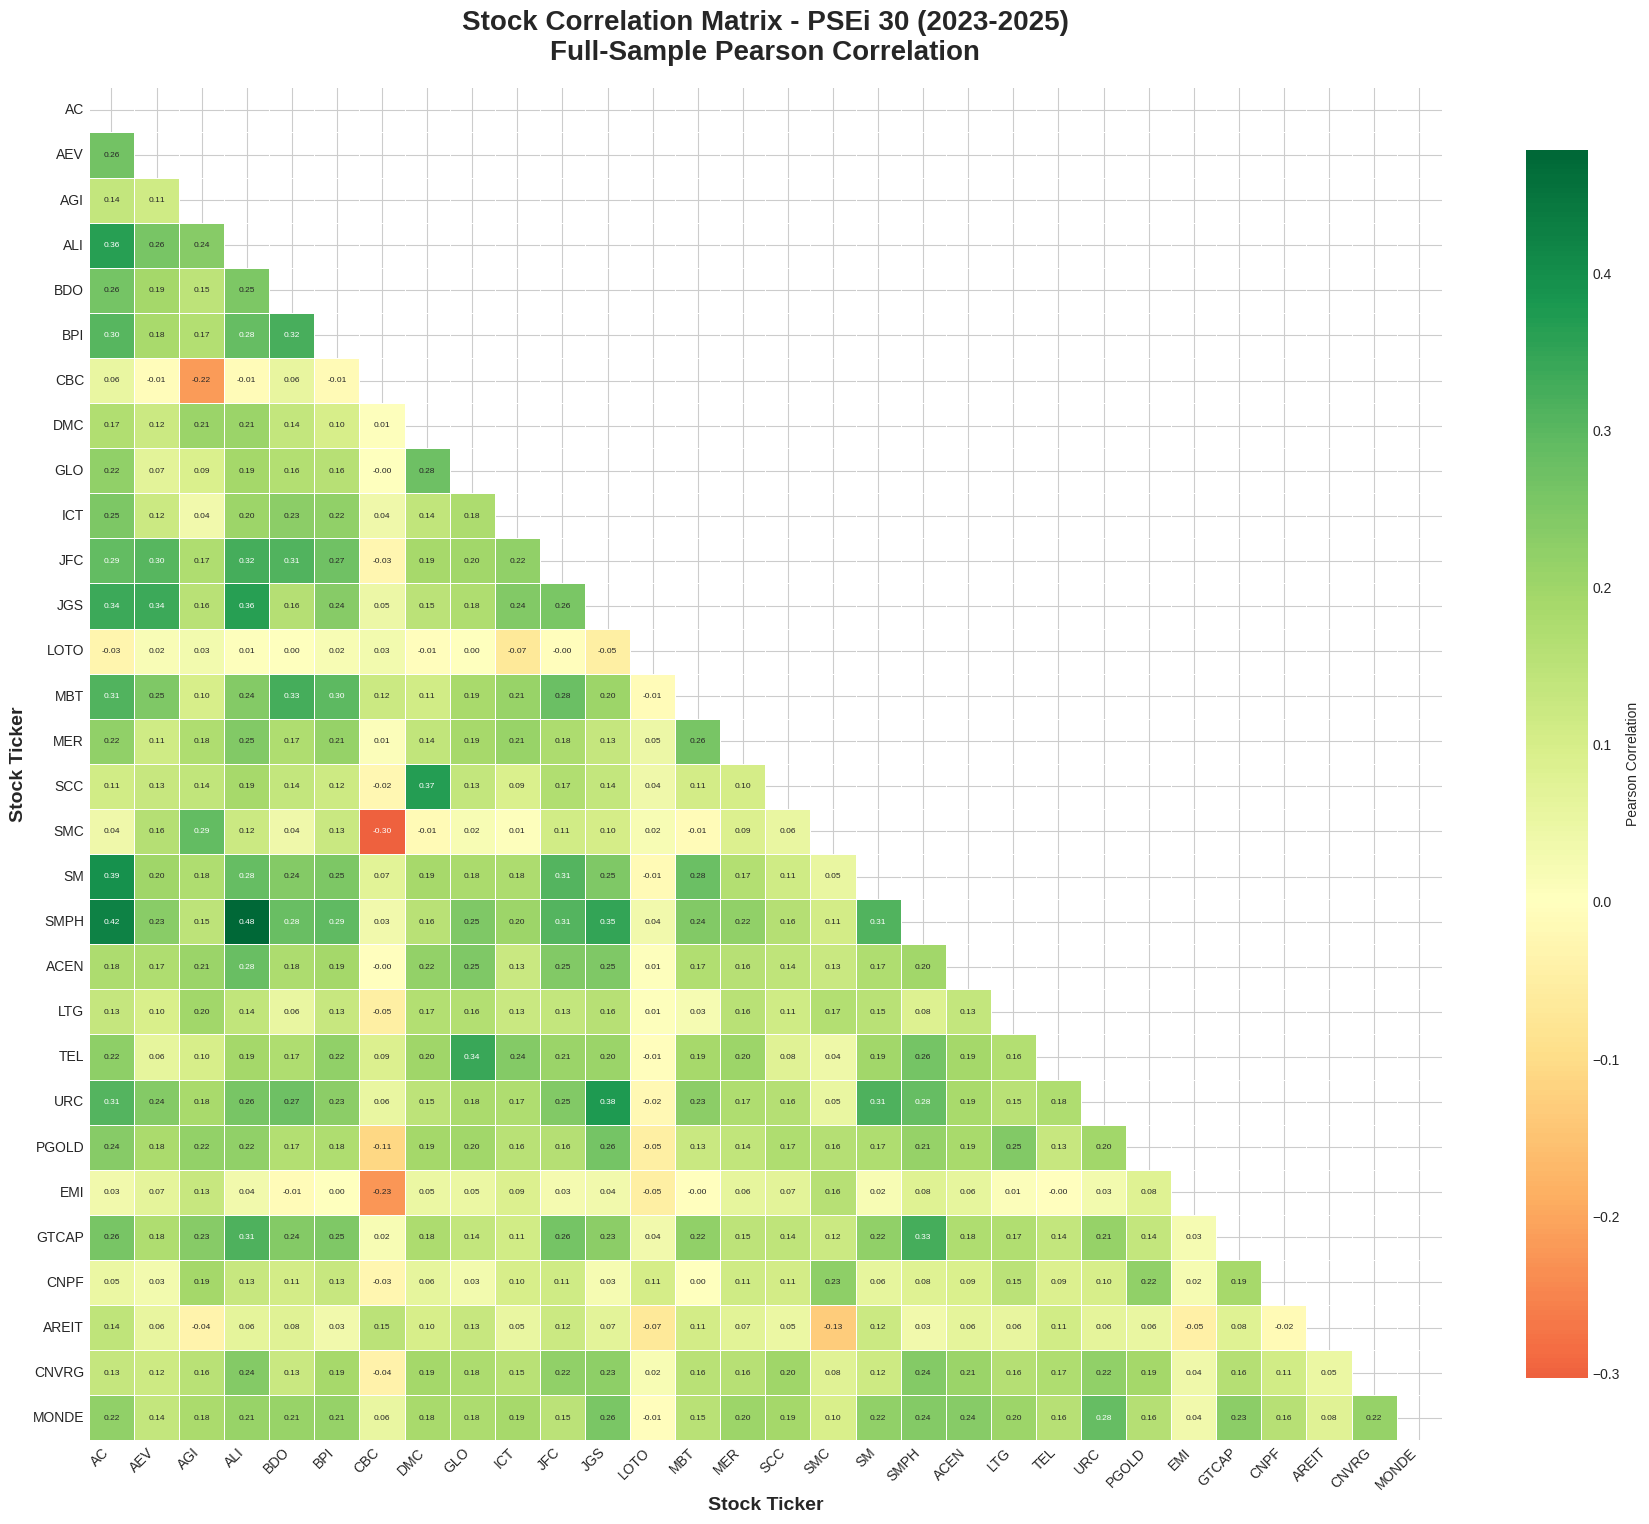

✓ Saved: 01_correlation_heatmap.png


In [ ]:
print("Creating Visualization 1: Correlation Heatmap...")

plt.figure(figsize=(18, 16))

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create heatmap
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"},
    annot_kws={'size': 6}
)

plt.title('Stock Correlation Matrix - PSEi 30 (2023-2025)\nFull-Sample Pearson Correlation',
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Stock Ticker', fontsize=14, fontweight='bold')
plt.ylabel('Stock Ticker', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('01_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 01_correlation_heatmap.png")

Creating Visualization 2: Distance Matrix Heatmap...


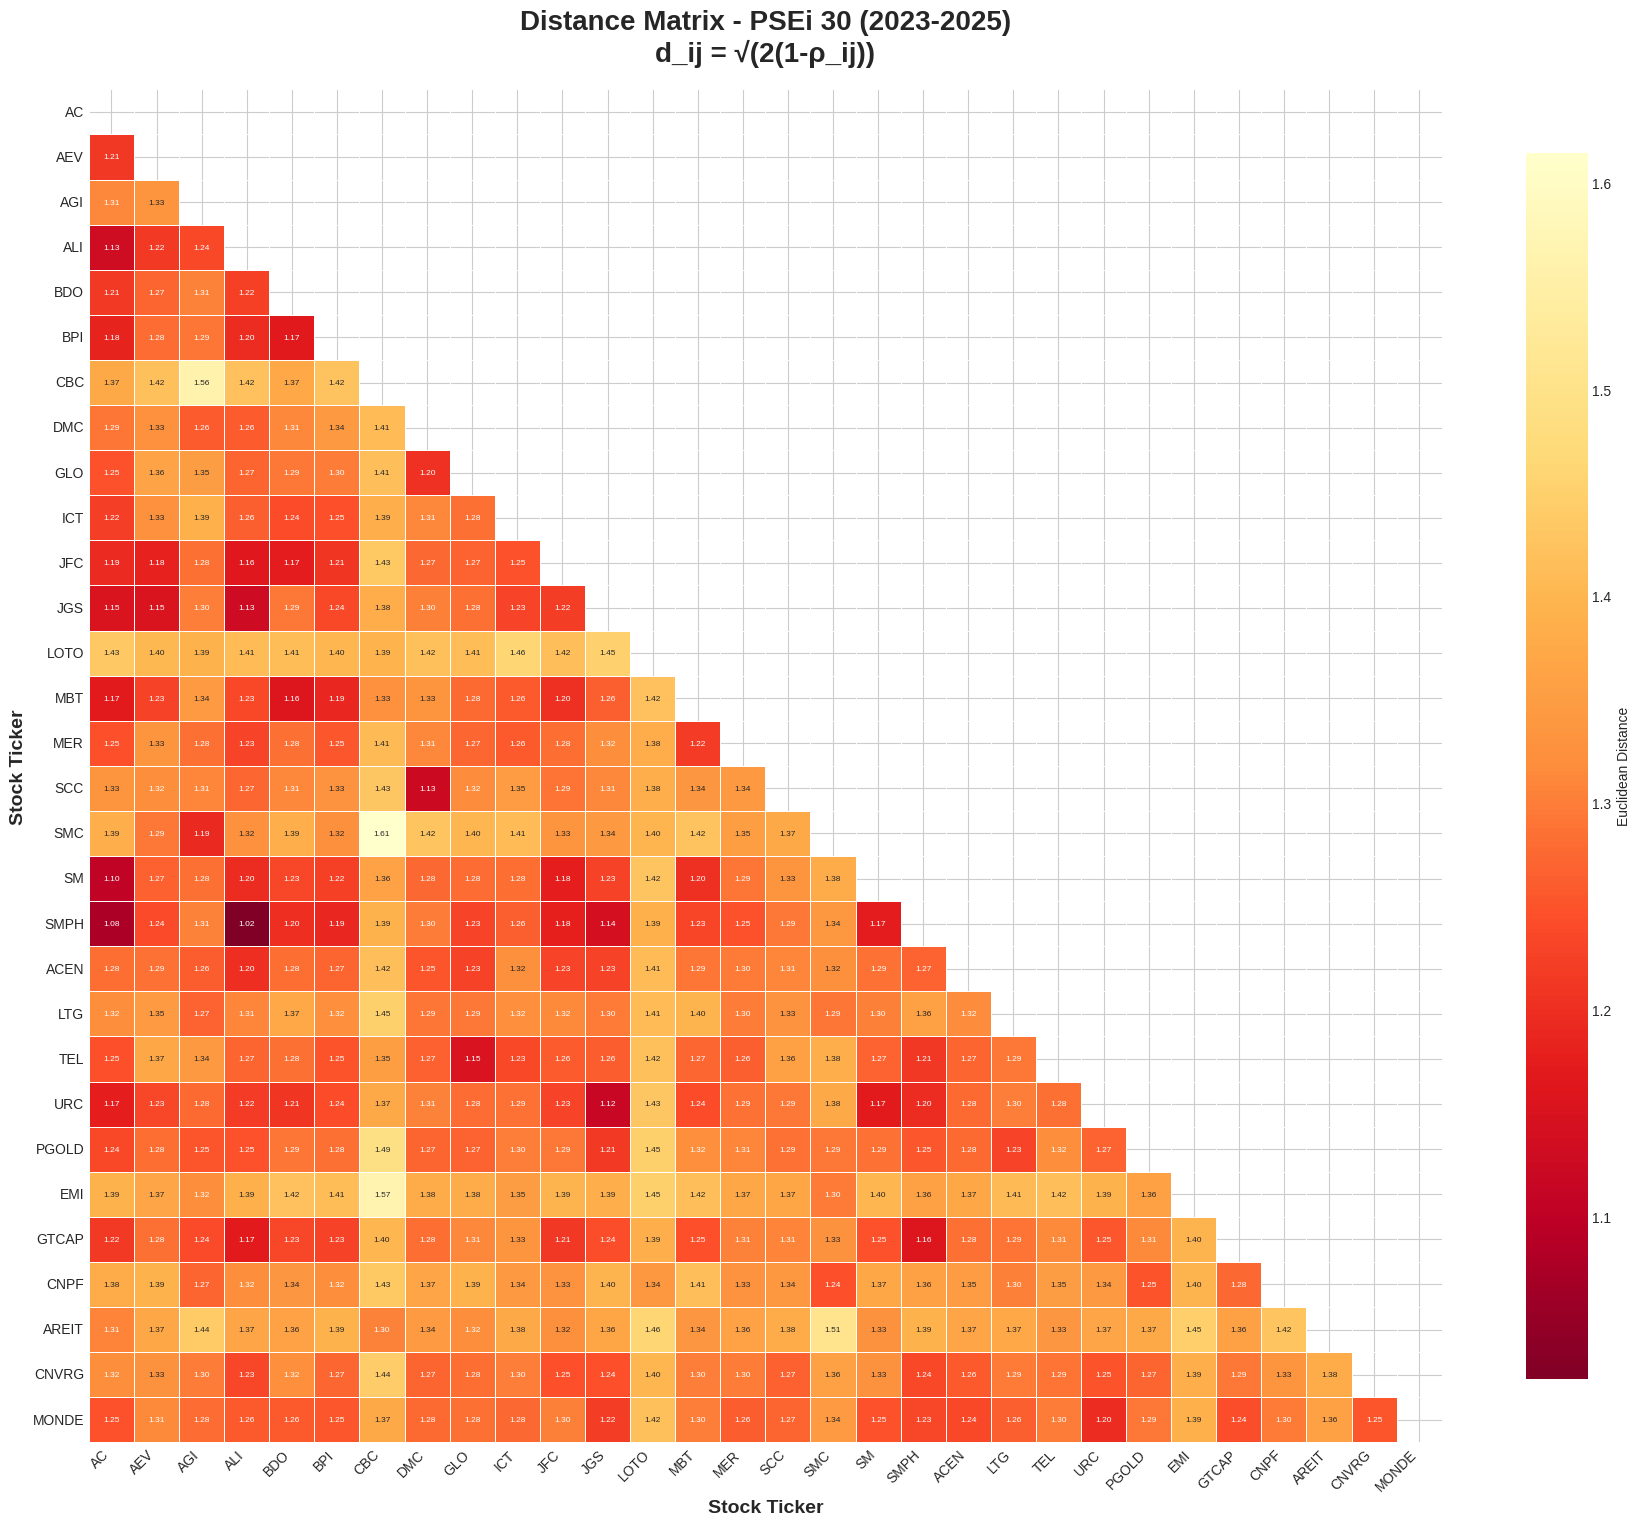

✓ Saved: 02_distance_matrix.png


In [ ]:
print("Creating Visualization 2: Distance Matrix Heatmap...")

plt.figure(figsize=(18, 16))

mask = np.triu(np.ones_like(distance_matrix, dtype=bool))

sns.heatmap(
    distance_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd_r',
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Euclidean Distance"},
    annot_kws={'size': 6}
)

plt.title('Distance Matrix - PSEi 30 (2023-2025)\nd_ij = √(2(1-ρ_ij))',
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Stock Ticker', fontsize=14, fontweight='bold')
plt.ylabel('Stock Ticker', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('02_distance_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 02_distance_matrix.png")

Creating Visualization 3: Minimum Spanning Tree...


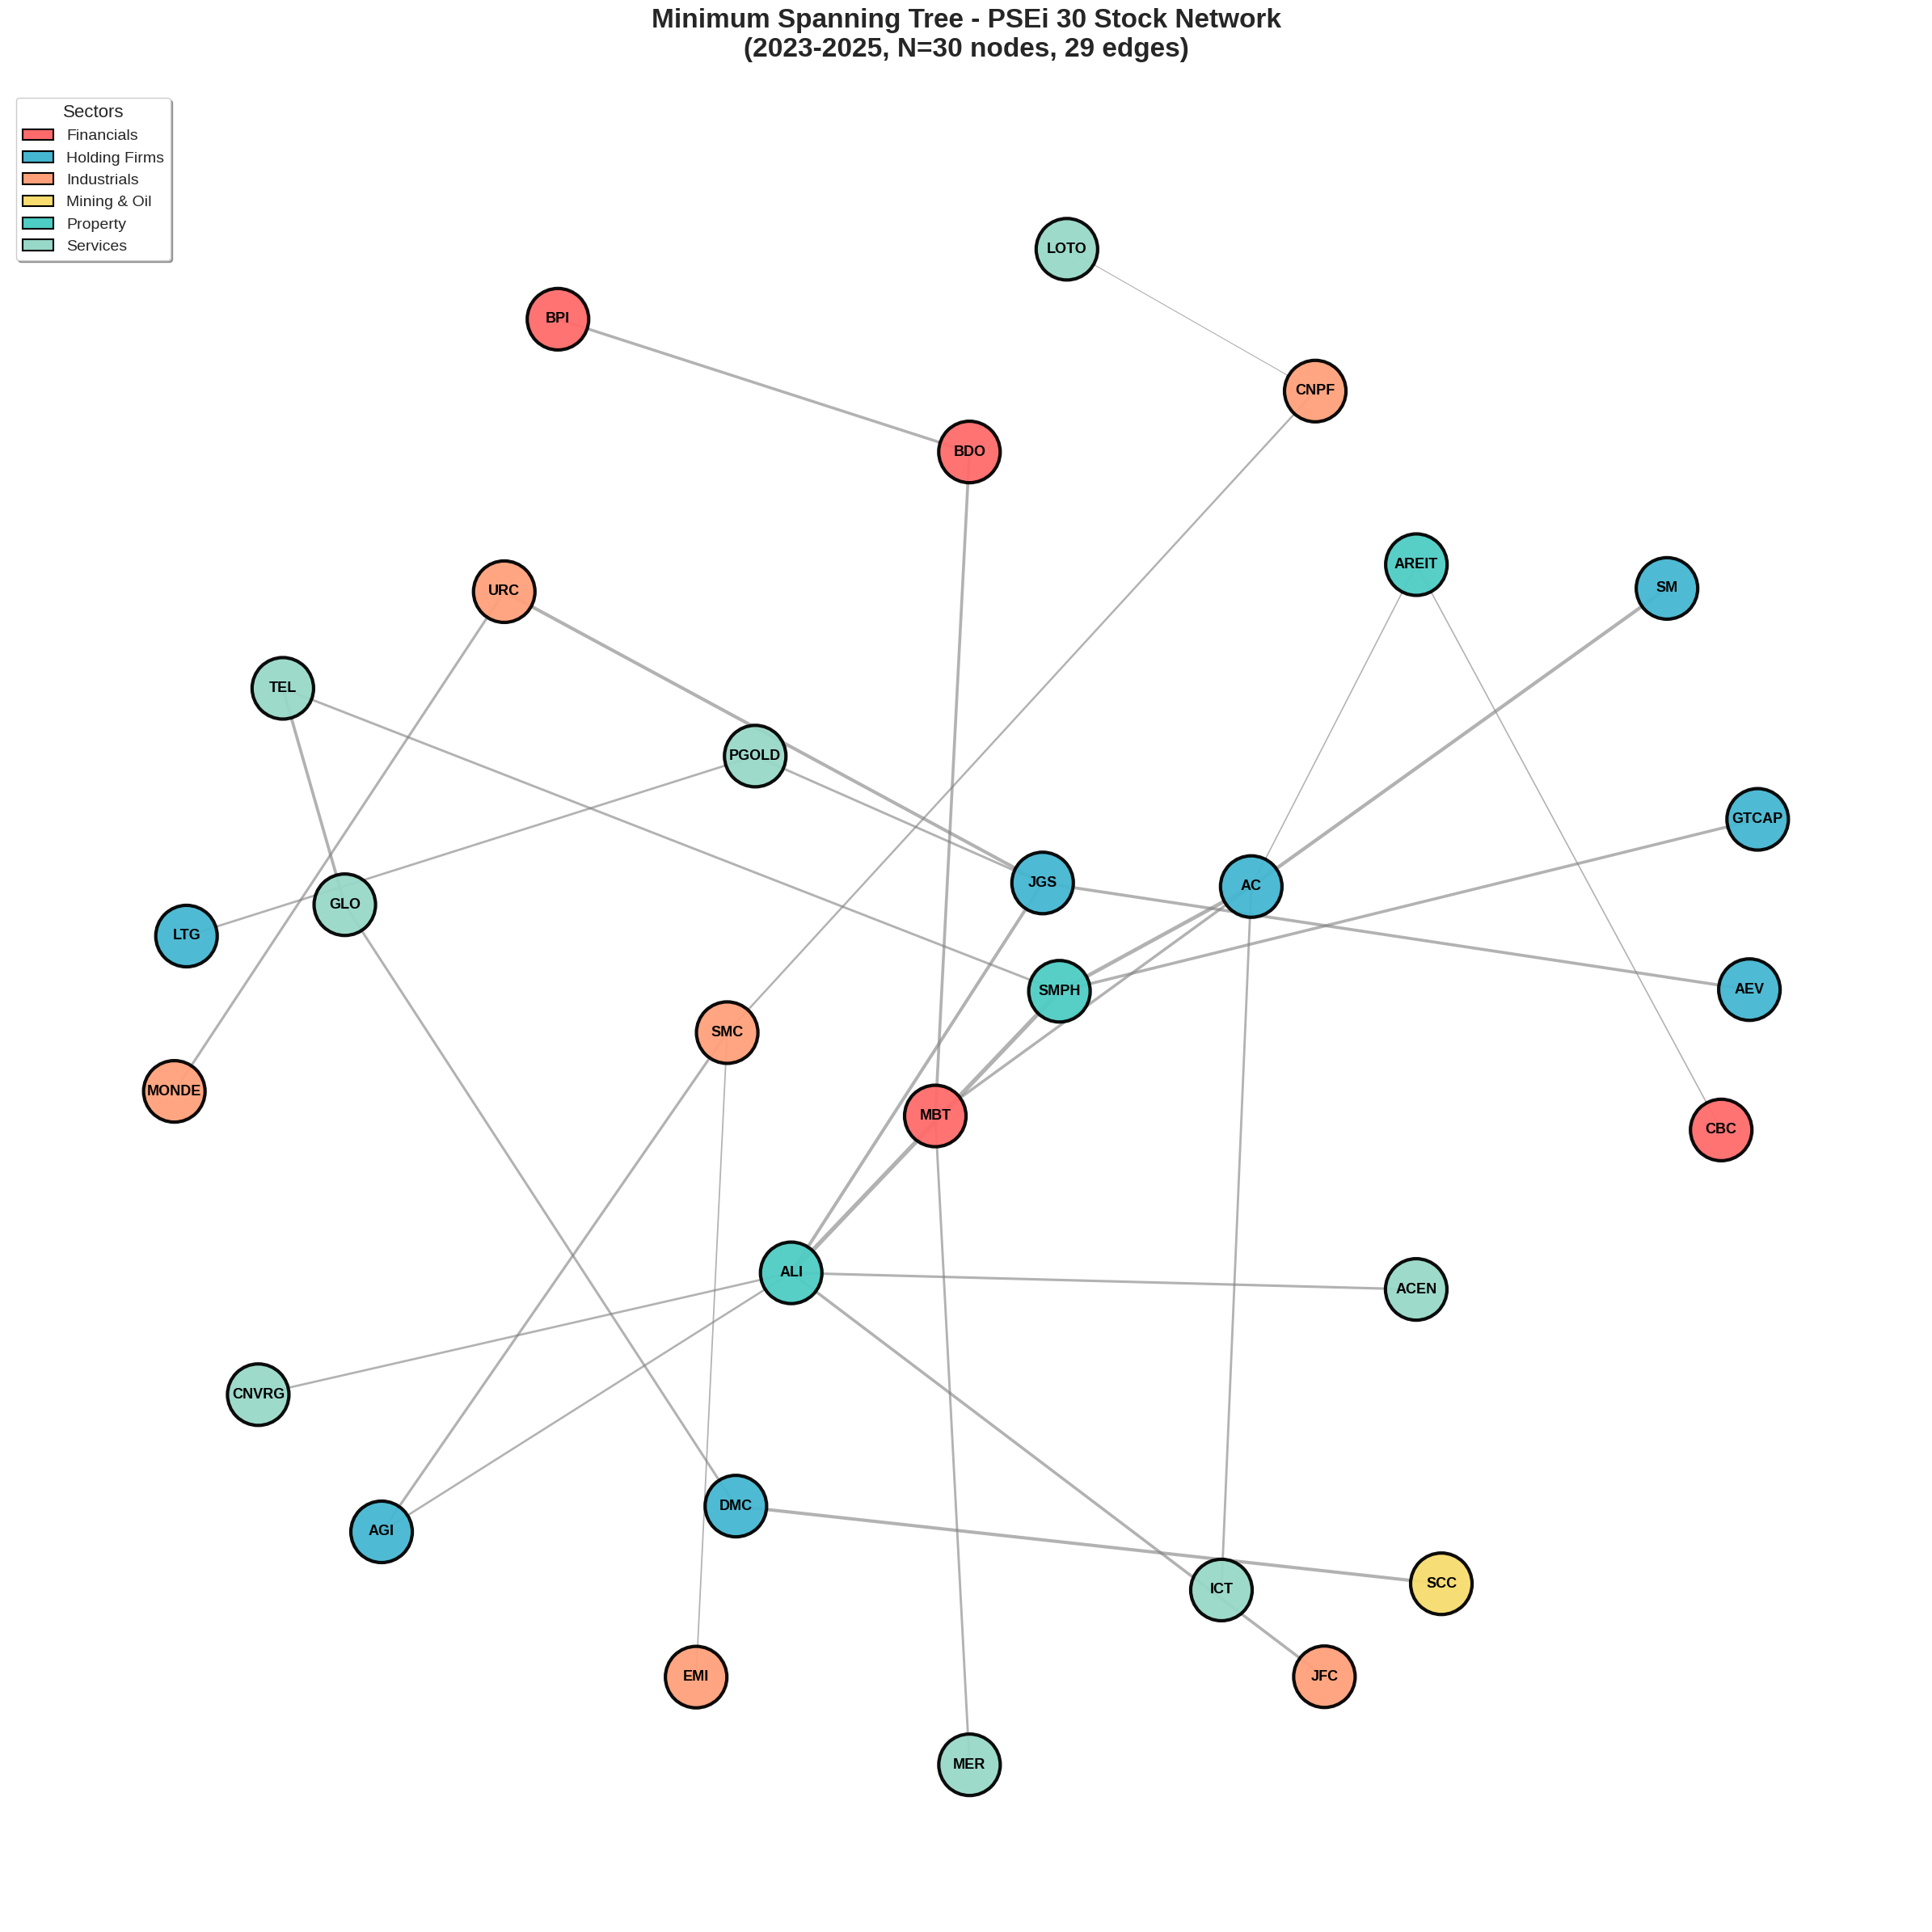

✓ Saved: 03_minimum_spanning_tree.png


In [ ]:
print("Creating Visualization 3: Minimum Spanning Tree...")

plt.figure(figsize=(24, 24))

# Node colors by sector
node_colors = [sector_colors.get(sector_map.get(node, 'Unknown'), '#CCCCCC')
               for node in MST.nodes()]

# Layout
pos = nx.spring_layout(MST, k=3, iterations=150, seed=42)

# Draw nodes
nx.draw_networkx_nodes(
    MST, pos,
    node_size=3000,
    node_color=node_colors,
    edgecolors='black',
    linewidths=3,
    alpha=0.95
)

# Draw labels
nx.draw_networkx_labels(
    MST, pos,
    font_size=13,
    font_weight='bold',
    font_family='sans-serif'
)

# Draw edges (thickness based on correlation strength)
edges = MST.edges()
correlations = [MST[u][v]['correlation'] for u, v in edges]
edge_widths = [abs(c) * 8 for c in correlations]

nx.draw_networkx_edges(
    MST, pos,
    width=edge_widths,
    alpha=0.6,
    edge_color='gray'
)

plt.title('Minimum Spanning Tree - PSEi 30 Stock Network\n(2023-2025, N=30 nodes, 29 edges)',
          fontsize=24, fontweight='bold', pad=30)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color, label=sector, edgecolor='black', linewidth=1.5)
    for sector, color in sorted(sector_colors.items())
]
plt.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=14,
    title='Sectors',
    title_fontsize=16,
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.axis('off')
plt.tight_layout()
plt.savefig('03_minimum_spanning_tree.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 03_minimum_spanning_tree.png")

Creating Visualization 4: Threshold Network (τ=0.3)...


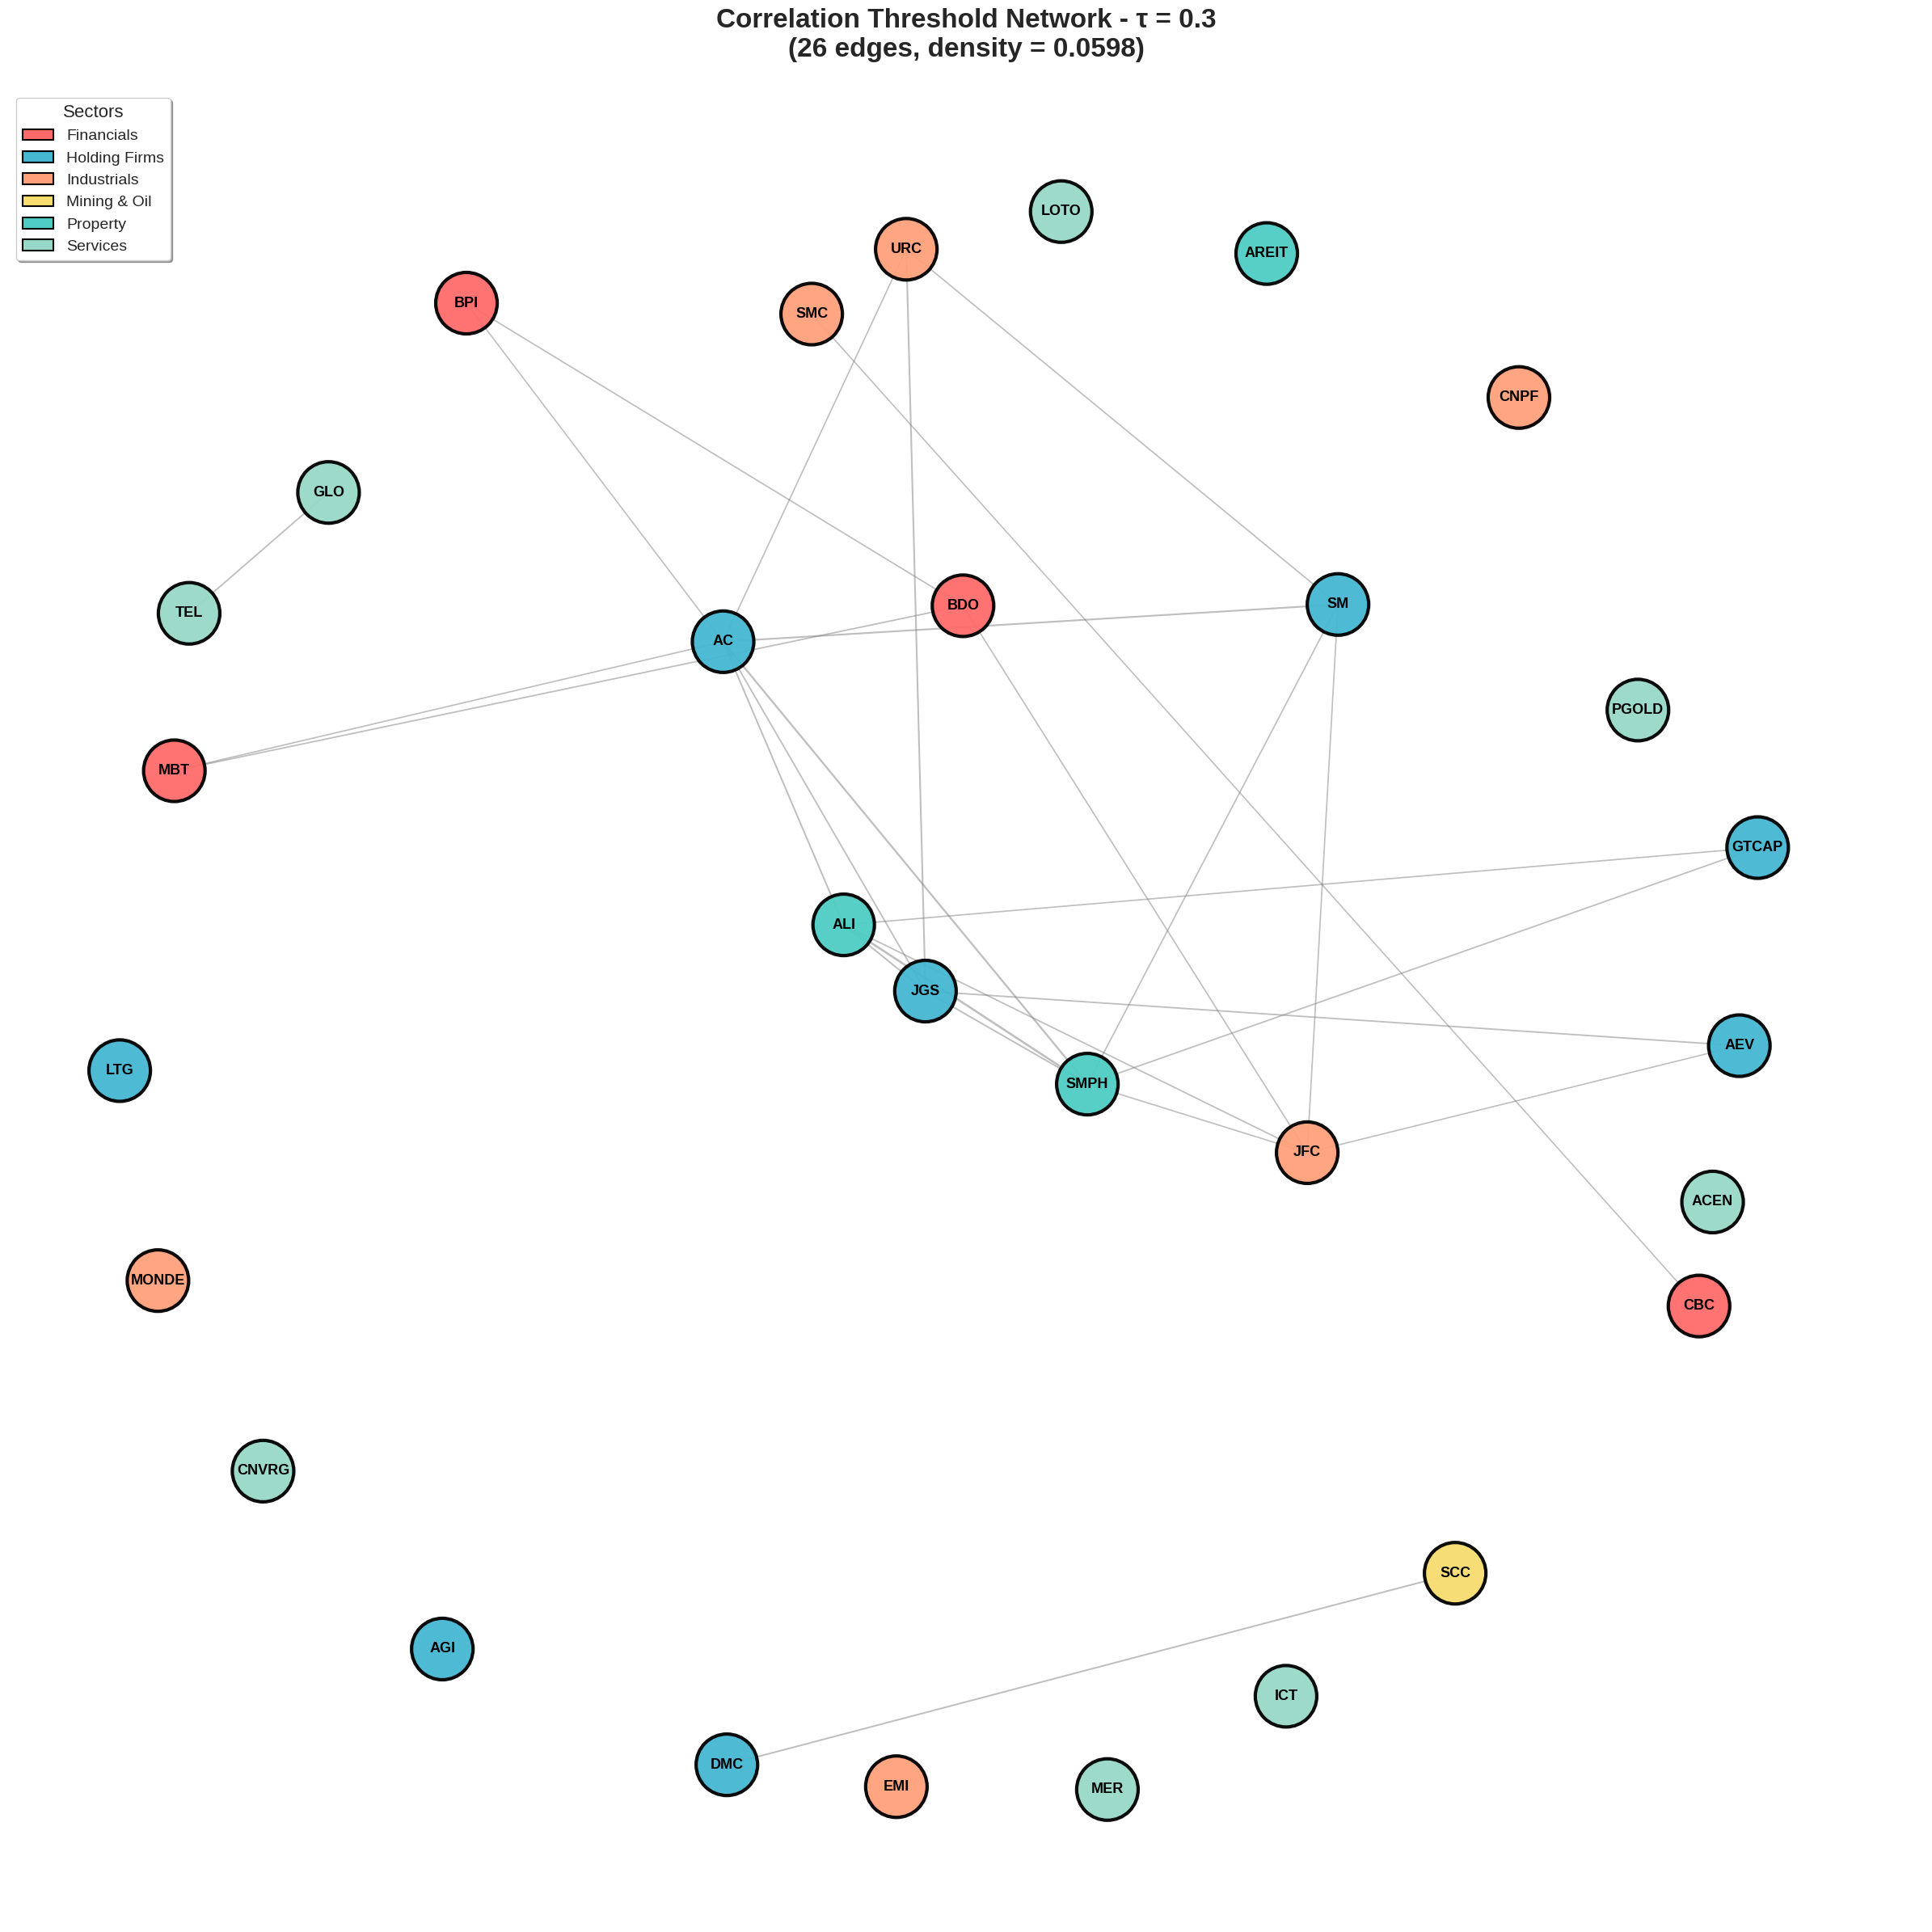

✓ Saved: 04_threshold_network_0.3.png


In [ ]:
print("Creating Visualization 4: Threshold Network (τ=0.3)...")

plt.figure(figsize=(24, 24))

node_colors = [sector_colors.get(sector_map.get(node, 'Unknown'), '#CCCCCC')
               for node in G_03.nodes()]

pos = nx.spring_layout(G_03, k=2.5, iterations=150, seed=42)

nx.draw_networkx_nodes(
    G_03, pos,
    node_size=3000,
    node_color=node_colors,
    edgecolors='black',
    linewidths=3,
    alpha=0.95
)

nx.draw_networkx_labels(
    G_03, pos,
    font_size=13,
    font_weight='bold',
    font_family='sans-serif'
)

edges = G_03.edges()
weights = [G_03[u][v]['weight'] for u, v in edges]
edge_widths = [w * 4 for w in weights]

nx.draw_networkx_edges(
    G_03, pos,
    width=edge_widths,
    alpha=0.5,
    edge_color='gray'
)

plt.title(f'Correlation Threshold Network - τ = 0.3\n({G_03.number_of_edges()} edges, density = {nx.density(G_03):.4f})',
          fontsize=24, fontweight='bold', pad=30)

plt.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=14,
    title='Sectors',
    title_fontsize=16,
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.axis('off')
plt.tight_layout()
plt.savefig('04_threshold_network_0.3.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 04_threshold_network_0.3.png")

Creating Visualization 5: Centrality Comparison...


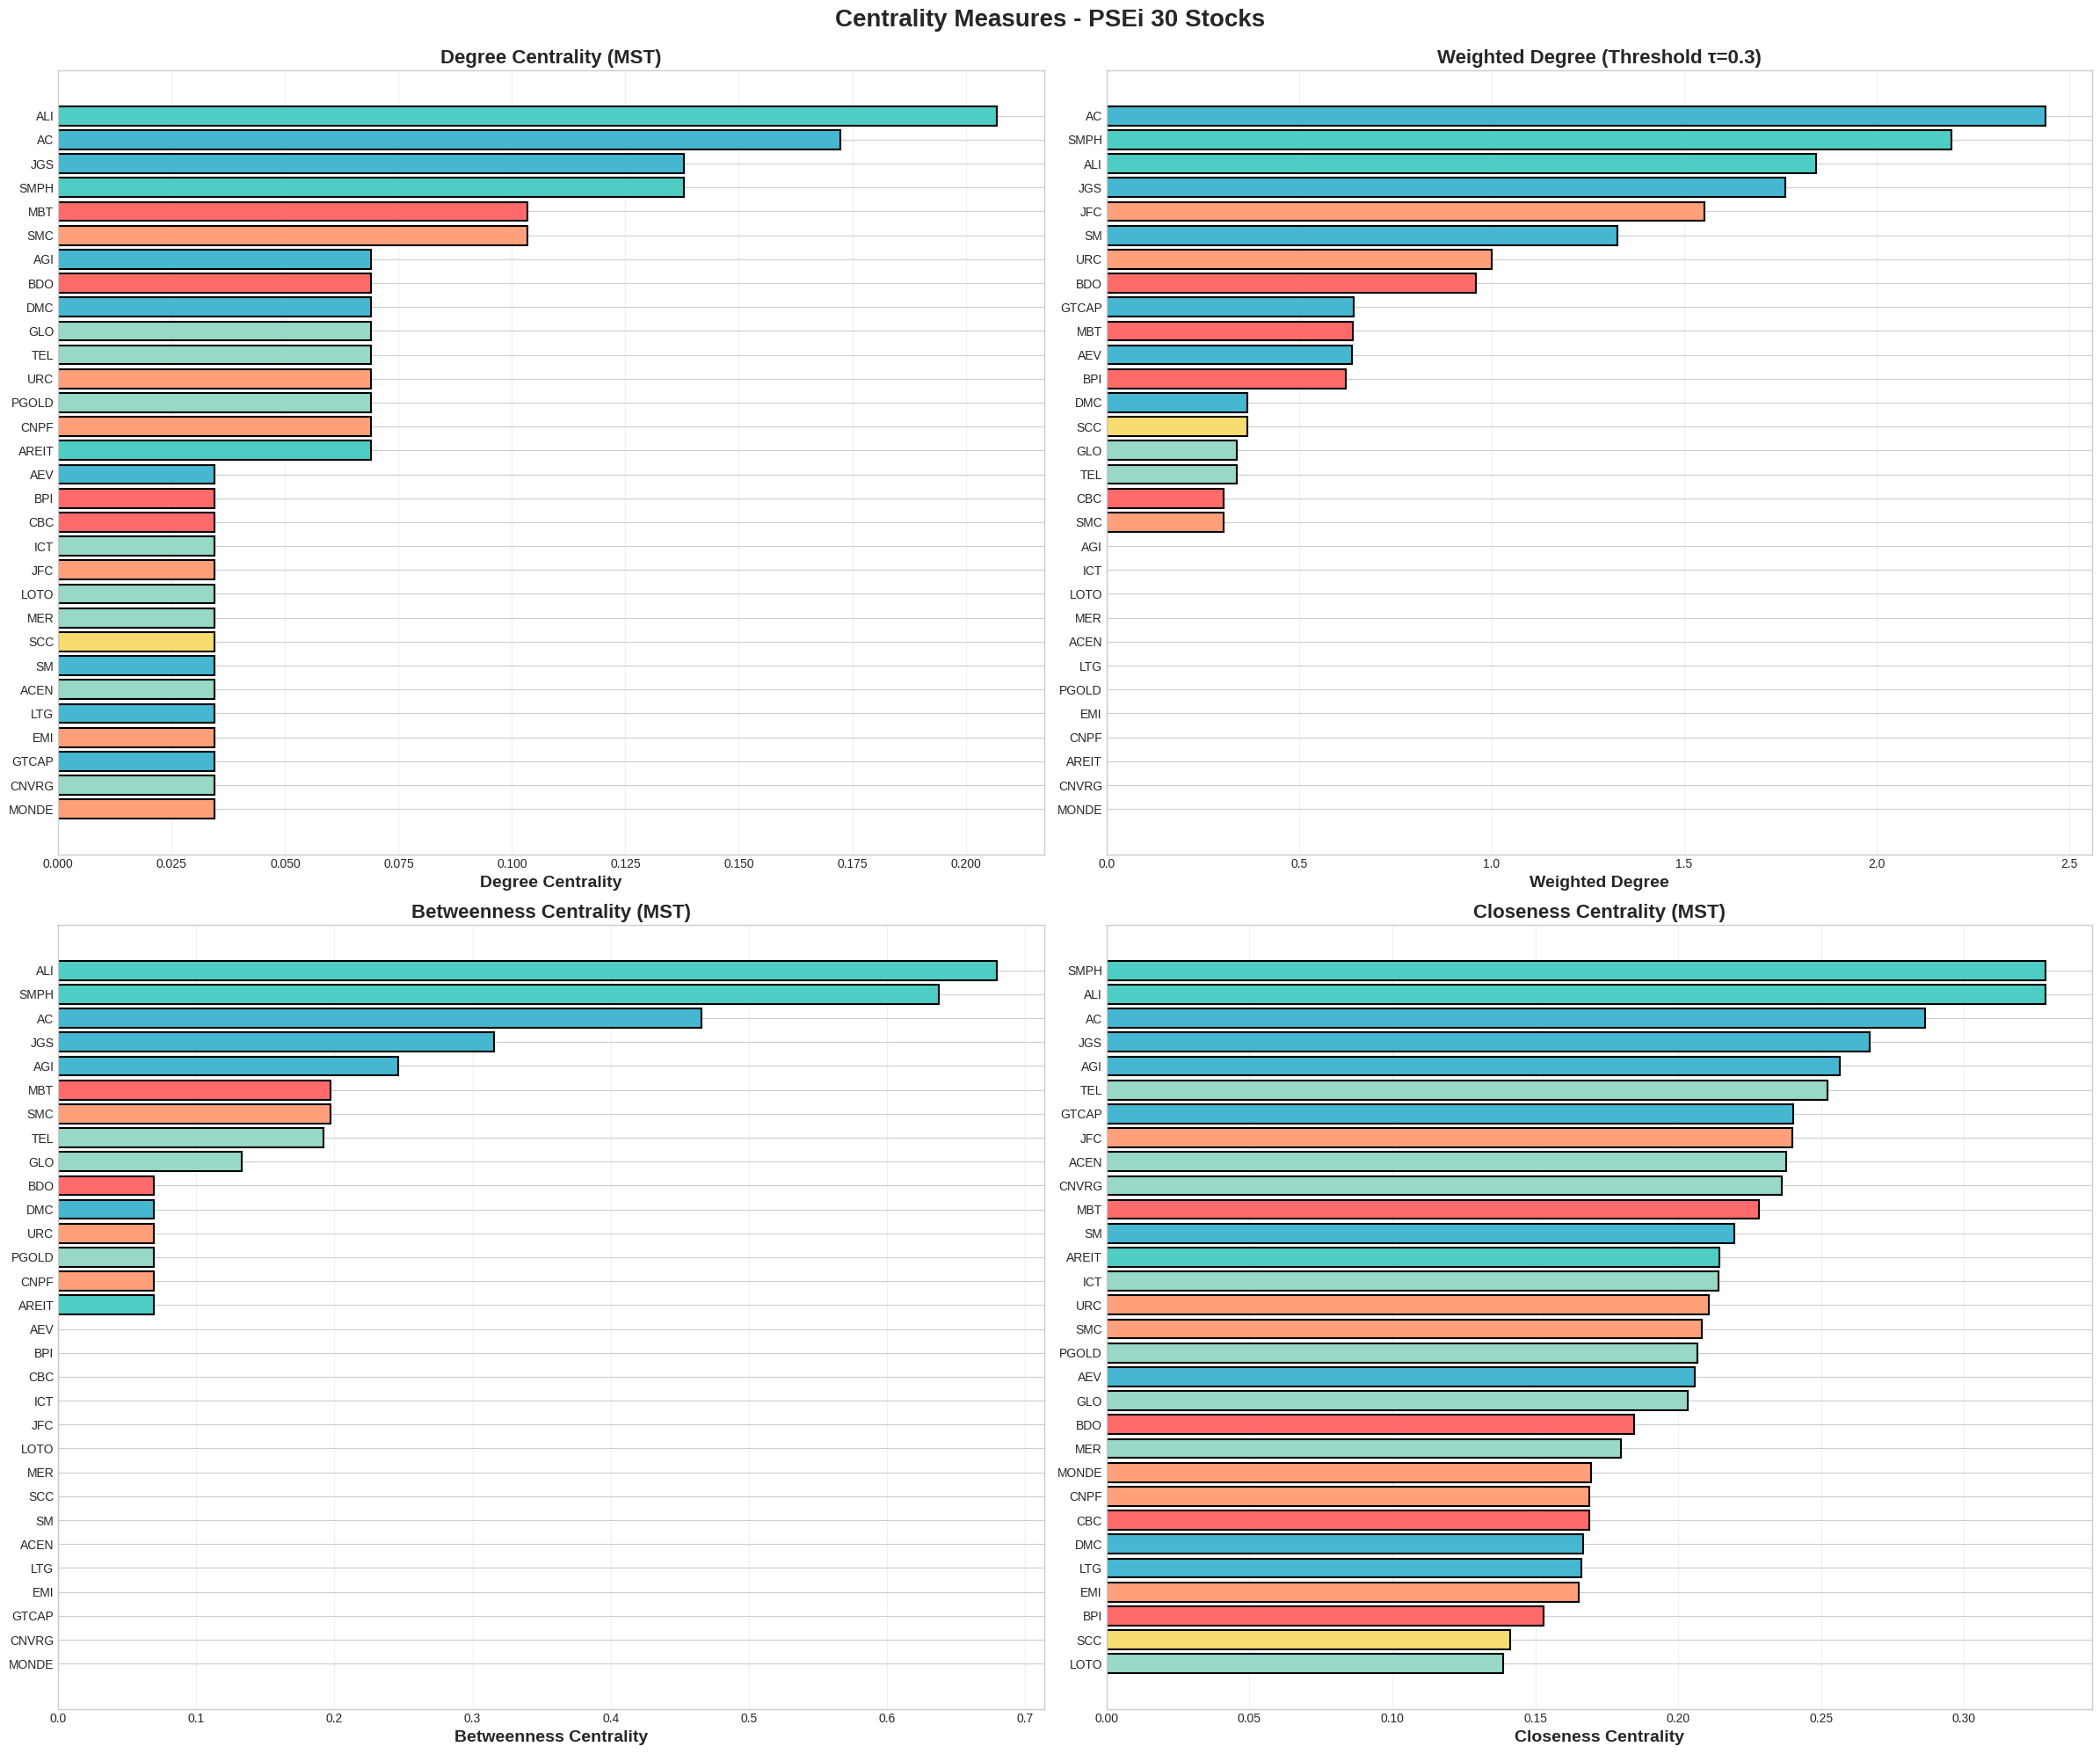

✓ Saved: 05_centrality_comparison.png


In [ ]:
print("Creating Visualization 5: Centrality Comparison...")

fig, axes = plt.subplots(2, 2, figsize=(24, 20))

# Sort data
sorted_deg_mst = sorted(degree_centrality_mst.items(), key=lambda x: x[1], reverse=True)
sorted_wd = sorted(weighted_degree.items(), key=lambda x: x[1], reverse=True)
sorted_between = sorted(betweenness_mst.items(), key=lambda x: x[1], reverse=True)
sorted_close = sorted(closeness_mst.items(), key=lambda x: x[1], reverse=True)

# Helper function for colors
def get_colors(stocks):
    return [sector_colors.get(sector_map.get(s, 'Unknown'), '#CCCCCC') for s in stocks]

# 1. Degree Centrality (MST)
ax1 = axes[0, 0]
stocks = [s for s, _ in sorted_deg_mst]
values = [v for _, v in sorted_deg_mst]
ax1.barh(stocks, values, color=get_colors(stocks), edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Degree Centrality', fontsize=14, fontweight='bold')
ax1.set_title('Degree Centrality (MST)', fontsize=16, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# 2. Weighted Degree (τ=0.3)
ax2 = axes[0, 1]
stocks = [s for s, _ in sorted_wd]
values = [v for _, v in sorted_wd]
ax2.barh(stocks, values, color=get_colors(stocks), edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Weighted Degree', fontsize=14, fontweight='bold')
ax2.set_title('Weighted Degree (Threshold τ=0.3)', fontsize=16, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# 3. Betweenness Centrality (MST)
ax3 = axes[1, 0]
stocks = [s for s, _ in sorted_between]
values = [v for _, v in sorted_between]
ax3.barh(stocks, values, color=get_colors(stocks), edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Betweenness Centrality', fontsize=14, fontweight='bold')
ax3.set_title('Betweenness Centrality (MST)', fontsize=16, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# 4. Closeness Centrality (MST)
ax4 = axes[1, 1]
stocks = [s for s, _ in sorted_close]
values = [v for _, v in sorted_close]
ax4.barh(stocks, values, color=get_colors(stocks), edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Closeness Centrality', fontsize=14, fontweight='bold')
ax4.set_title('Closeness Centrality (MST)', fontsize=16, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()

plt.suptitle('Centrality Measures - PSEi 30 Stocks', fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('05_centrality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 05_centrality_comparison.png")

Creating Visualization 6: Sector Connectivity Heatmap...


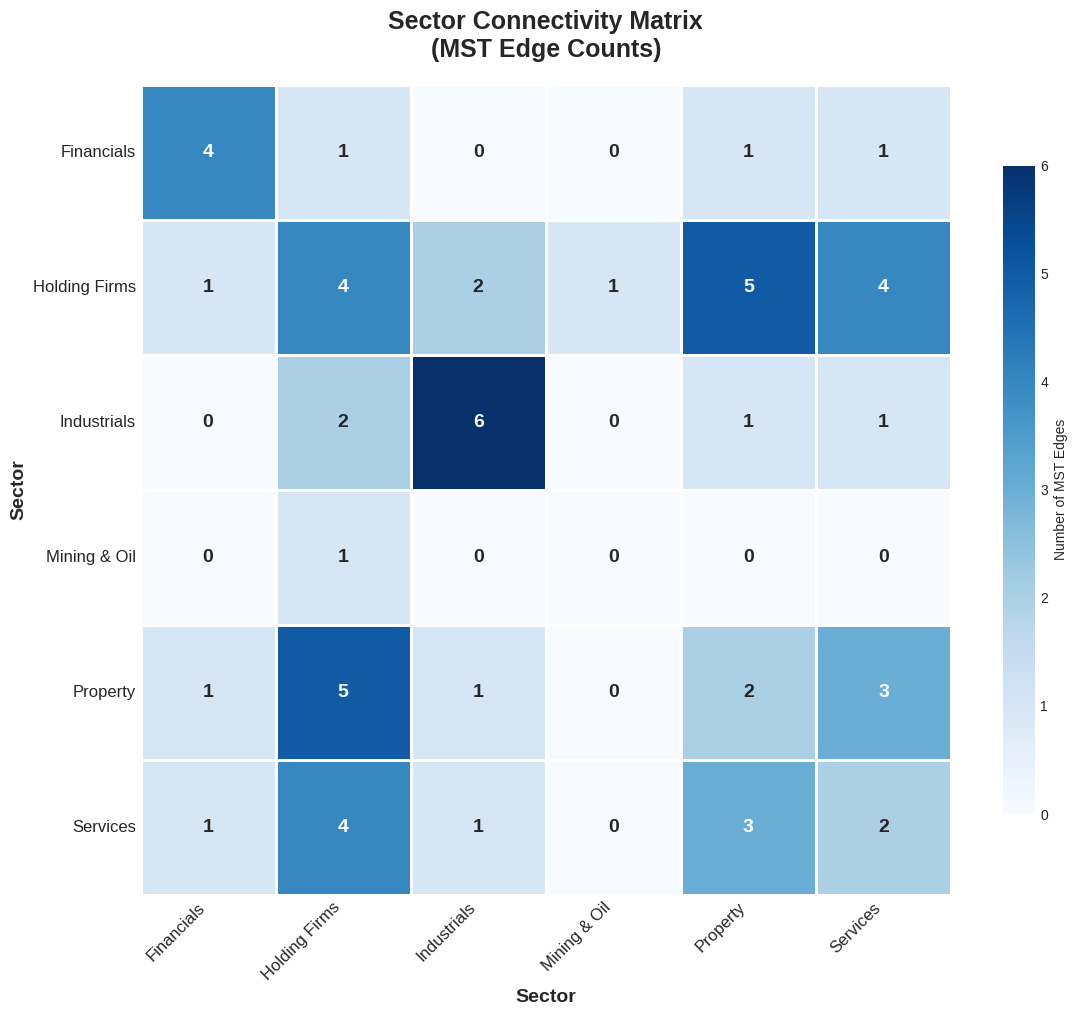

✓ Saved: 06_sector_connectivity.png


In [ ]:
print("Creating Visualization 6: Sector Connectivity Heatmap...")

plt.figure(figsize=(12, 10))

sns.heatmap(
    sector_connectivity,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    linewidths=2,
    linecolor='white',
    cbar_kws={"shrink": 0.8, "label": "Number of MST Edges"},
    annot_kws={'size': 14, 'weight': 'bold'}
)

plt.title('Sector Connectivity Matrix\n(MST Edge Counts)',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sector', fontsize=14, fontweight='bold')
plt.ylabel('Sector', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.savefig('06_sector_connectivity.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 06_sector_connectivity.png")

In [ ]:
print("="*70)
print("SAVING ALL RESULTS")
print("="*70)
print()

# Centrality results table
centrality_results = pd.DataFrame({
    'Stock': stocks,
    'Sector': [sector_map.get(s, 'Unknown') for s in stocks],
    'Degree_Centrality_MST': [degree_centrality_mst.get(s, 0) for s in stocks],
    'Degree_MST': [degree_dict_mst.get(s, 0) for s in stocks],
    'Weighted_Degree_0.3': [weighted_degree.get(s, 0) for s in stocks],
    'Betweenness_MST': [betweenness_mst.get(s, 0) for s in stocks],
    'Closeness_MST': [closeness_mst.get(s, 0) for s in stocks],
    'Clustering_Coef_0.3': [clustering_03.get(s, 0) for s in stocks]
})

centrality_results = centrality_results.sort_values('Degree_Centrality_MST', ascending=False)
centrality_results.to_csv('centrality_results.csv', index=False)
print("✓ Saved: centrality_results.csv")

print()
print("="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print()
print("Generated Files:")
print()
print("📊 DATA FILES:")
print("  • stock_log_returns.csv")
print("  • correlation_matrix.csv")
print("  • distance_matrix.csv")
print("  • centrality_results.csv")
print("  • network_statistics.csv")
print("  • sector_connectivity.csv")
print()
print("📈 VISUALIZATIONS:")
print("  • 01_correlation_heatmap.png")
print("  • 02_distance_matrix.png")
print("  • 03_minimum_spanning_tree.png")
print("  • 04_threshold_network_0.3.png")
print("  • 05_centrality_comparison.png")
print("  • 06_sector_connectivity.png")
print("  • 07_correlation_distribution.png")
print()
print("="*70)

SAVING ALL RESULTS

✓ Saved: centrality_results.csv

ANALYSIS COMPLETE!

Generated Files:

📊 DATA FILES:
  • stock_log_returns.csv
  • correlation_matrix.csv
  • distance_matrix.csv
  • centrality_results.csv
  • network_statistics.csv
  • sector_connectivity.csv

📈 VISUALIZATIONS:
  • 01_correlation_heatmap.png
  • 02_distance_matrix.png
  • 03_minimum_spanning_tree.png
  • 04_threshold_network_0.3.png
  • 05_centrality_comparison.png
  • 06_sector_connectivity.png
  • 07_correlation_distribution.png



In [ ]:
print("="*70)
print("FINAL SUMMARY REPORT")
print("="*70)
print()

print("KEY FINDINGS:")
print()

print("1. MOST CENTRAL STOCKS (MST):")
for rank, (stock, cent) in enumerate(sorted_degree[:5], 1):
    sector = sector_map.get(stock, '?')
    connections = degree_dict_mst[stock]
    print(f"   {rank}. {stock:8s} ({sector:15s}) - {connections} connections")

print()
print("2. HIGHEST WEIGHTED DEGREE (τ=0.3):")
for rank, (stock, wd) in enumerate(sorted_wd[:5], 1):
    sector = sector_map.get(stock, '?')
    print(f"   {rank}. {stock:8s} ({sector:15s}) - {wd:.4f}")

print()
print("3. CORRELATION STATISTICS:")
print(f"   Average correlation: {corr_values.mean():.4f}")
print(f"   Median correlation: {np.median(corr_values):.4f}")
print(f"   Correlation std dev: {corr_values.std():.4f}")

print()
print("4. SECTORAL STRUCTURE:")
print(f"   Within-sector MST edges: {within_sector} ({within_sector/total_mst_edges*100:.1f}%)")
print(f"   Between-sector MST edges: {between_sector} ({between_sector/total_mst_edges*100:.1f}%)")

print()
print("5. NETWORK TOPOLOGY:")
print(f"   MST density: {nx.density(MST):.6f}")
print(f"   MST diameter: {nx.diameter(MST)}")
print(f"   Threshold network (τ=0.3) density: {nx.density(G_03):.4f}")
print(f"   Average clustering (τ=0.3): {nx.average_clustering(G_03):.4f}")

print()
print("="*70)
print("ALL ANALYSIS COMPLETE!")
print("="*70)

FINAL SUMMARY REPORT

KEY FINDINGS:

1. MOST CENTRAL STOCKS (MST):
   1. ALI      (Property       ) - 6 connections
   2. AC       (Holding Firms  ) - 5 connections
   3. JGS      (Holding Firms  ) - 4 connections
   4. SMPH     (Property       ) - 4 connections
   5. MBT      (Financials     ) - 3 connections

2. HIGHEST WEIGHTED DEGREE (τ=0.3):
   1. AC       (Holding Firms  ) - 2.4378
   2. SMPH     (Property       ) - 2.1947
   3. ALI      (Property       ) - 1.8431
   4. JGS      (Holding Firms  ) - 1.7623
   5. JFC      (Industrials    ) - 1.5537

3. CORRELATION STATISTICS:
   Average correlation: 0.1440
   Median correlation: 0.1567
   Correlation std dev: 0.1024

4. SECTORAL STRUCTURE:
   Within-sector MST edges: 9 (31.0%)
   Between-sector MST edges: 20 (69.0%)

5. NETWORK TOPOLOGY:
   MST density: 0.066667
   MST diameter: 9
   Threshold network (τ=0.3) density: 0.0598
   Average clustering (τ=0.3): 0.1340

ALL ANALYSIS COMPLETE!


In [ ]:
print("="*70)
print("THRESHOLD COMPARISON ANALYSIS")
print("="*70)
print()

print("Comparing Networks at Different Correlation Thresholds:")
print()

# Compare all three thresholds
comparison_data = []

for tau in [0.3, 0.4, 0.5]:
    G = threshold_networks[tau]

    avg_clustering = nx.average_clustering(G) if G.number_of_edges() > 0 else 0

    comparison_data.append({
        'Threshold (τ)': tau,
        'Edges': G.number_of_edges(),
        'Density': f"{nx.density(G):.4f}",
        'Avg Degree': f"{(2 * G.number_of_edges() / G.number_of_nodes()):.2f}",
        'Avg Clustering': f"{avg_clustering:.4f}"
    })

    print(f"τ = {tau}:")
    print(f"  Edges: {G.number_of_edges()}")
    print(f"  Density: {nx.density(G):.4f}")
    print(f"  Average Degree: {(2 * G.number_of_edges() / G.number_of_nodes()):.2f}")
    print(f"  Average Clustering: {avg_clustering:.4f}")

    # Top 3 most connected
    degree_dict = dict(G.degree())
    top_3 = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"  Top 3 Connected: {', '.join([f'{s} ({d})' for s, d in top_3])}")
    print()

# Create comparison table
comparison_df = pd.DataFrame(comparison_data)
print("Threshold Comparison Table:")
print(comparison_df.to_string(index=False))
print()

# Save
comparison_df.to_csv('threshold_comparison.csv', index=False)
print("✓ Saved: threshold_comparison.csv")

THRESHOLD COMPARISON ANALYSIS

Comparing Networks at Different Correlation Thresholds:

τ = 0.3:
  Edges: 26
  Density: 0.0598
  Average Degree: 1.73
  Average Clustering: 0.1340
  Top 3 Connected: AC (7), SMPH (6), ALI (5)

τ = 0.4:
  Edges: 2
  Density: 0.0046
  Average Degree: 0.13
  Average Clustering: 0.0000
  Top 3 Connected: SMPH (2), AC (1), ALI (1)

τ = 0.5:
  Edges: 0
  Density: 0.0000
  Average Degree: 0.00
  Average Clustering: 0.0000
  Top 3 Connected: AC (0), AEV (0), AGI (0)

Threshold Comparison Table:
 Threshold (τ)  Edges Density Avg Degree Avg Clustering
           0.3     26  0.0598       1.73         0.1340
           0.4      2  0.0046       0.13         0.0000
           0.5      0  0.0000       0.00         0.0000

✓ Saved: threshold_comparison.csv
